In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
import math
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import re
import os
import sys
from pathlib import Path
path = Path.cwd()
input_dir = path.parent
import cv2
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import functional as F
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split, StratifiedKFold
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import wandb

# __print__ = print
# def print(string):
#     os.system(f'echo \"{string}\"')
#     __print__(string)
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Configuration

In [2]:
train_dir = input_dir/'train'
test_dir = input_dir/'test'
checkpoint_dir = input_dir/"experiment/checkpoint"

cfg = {}

In [3]:
all_image_ids = [p.stem for p in train_dir.iterdir()]

In [4]:
df = pd.read_csv(input_dir/'train.csv')
test_df = pd.read_csv(input_dir/"sample_submission.csv")
annotated_df = pd.read_csv(input_dir/"test_df.csv")

In [5]:
def get_bboxes_areas(row_box):
    bbox = np.fromstring(row_box[1:-1], sep=",")
    x, y, w, h = bbox
    return x, y, x+w, y+h, w, h, w*h

def show_boxes(img_id, df):
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    image_path = os.path.join(train_dir, img_id+'.jpg')
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    boxes = df.loc[df.image_id==img_id, ["xmin", "ymin", "xmax", "ymax"]].values
    for box in boxes:
        cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (255, 0, 0), 2)
    ax.imshow(image)

In [6]:
df['xmin'] = -1
df['ymin'] = -1
df['xmax'] = -1
df['ymax'] = -1
df['w'] = -1
df['h'] = -1
df['area'] = 0
df[['xmin', 'ymin', 'xmax', 'ymax', 'w', 'h', 'area']] = np.stack(df['bbox'].apply(lambda row_box: get_bboxes_areas(row_box)))
df.drop(columns=["bbox"], inplace=True)
df.head(1)

,image_id,width,height,source,xmin,ymin,xmax,ymax,w,h,area
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,890.0,258.0,56.0,36.0,2016.0


## EDA

#### Removing small boxes

In [7]:
df = df.drop(df.loc[(df.w<20)|(df.h<20)].index.values, axis=0)

#### Add non annotated boxes

In [8]:
non_annotated_images = list(set(all_image_ids) - set(df.image_id.values))

In [9]:
for img_id in non_annotated_images:
    row = {"image_id": img_id,
           "width": 1024,
           "height": 1024,
           "source": "",
           "xmin": 0,
           "ymin": 0,
           "xmax": 1,
           "ymax": 1,
           "w": 1,
           "h": 1,
           "area": 1}
    df = df.append(row, ignore_index=True)

## Stratified KFold Split Train, Val 

In [10]:
%time
folds_df = df.groupby(["image_id", "source"])["source"].count().to_frame(name="bbox_count").reset_index()
folds_df['stratify_group'] = np.char.add(folds_df["source"].values.astype(str), folds_df['bbox_count'].apply(lambda x: f'_{x // 20}').values.astype(str))
folds_df['mean_area'] = df.groupby(["image_id"])["area"].mean().values
folds_df['std_area'] = df.groupby(["image_id"])["area"].std().values
folds_df['fold'] = 0
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
for fold, (train_index, test_index) in enumerate(skf.split(folds_df, folds_df.stratify_group)):
    folds_df.loc[test_index, 'fold'] = fold
folds_df.head(1)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.58 µs


/home/adnen/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


,image_id,source,bbox_count,stratify_group,mean_area,std_area,fold
0,00333207f,arvalis_1,55,arvalis_1_2,6375.381818,4341.766616,1


In [11]:
folds_df.mean_area.min()

1.0

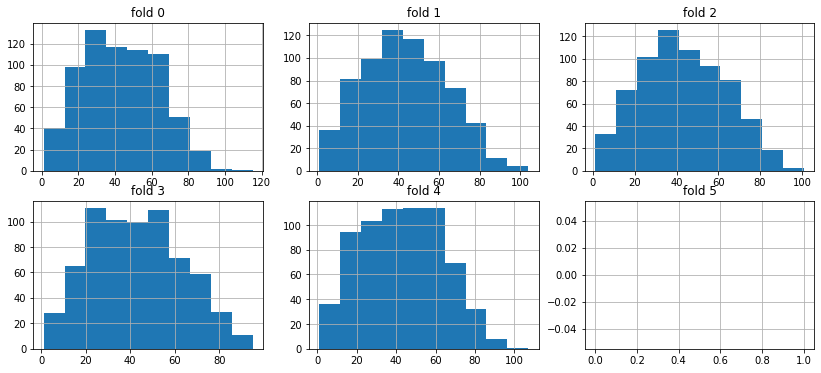

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(14, 6))
axes = axes.reshape(6)
for i, ax in enumerate(axes):
    folds_df.loc[folds_df.fold==i].bbox_count.hist(ax=ax) #axes[i // 2][i % 3])
    ax.set_title(f"fold {i}")
    

In [13]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
for fold, (train_index, test_index) in enumerate(skf.split(folds_df, folds_df.stratify_group)):
    folds_df.loc[test_index, 'fold'] = fold

/home/adnen/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [14]:
def get_train_val_indexes(df, fold):
    val_df = df.loc[df.fold==fold]
    train_df = df.loc[df.fold!=fold]
    return train_df.image_id.values, val_df.image_id.values


## DataSet

In [567]:
def show_boxes(image, target):
#     image, target = next(iter(dataset))
    image = image.permute(1, 2, 0).contiguous().numpy()
    boxes = target["boxes"].numpy().astype(int) # coco "boxes" pascal_voc bboxes
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    for box in boxes:
        cv2.rectangle(image,
                    (box[0], box[1]),
                    (box[2], box[3]),
                    (200, 0, 0), 3)
    plt.imshow(image)

def merge_targets(target1, target2):
    target = dict()
    for key in target1.keys():
        if key == "boxes":
            merged_value = np.concatenate([target1[key], target2[key]])
        elif key == "image_id":
            merged_value = target1[key]
        else:
            merged_value = torch.cat([target1[key], target2[key]])
        #print(key, len(merged_value))
        target[key] = merged_value
    return target

def mixup_images(images1, images2):
    mixed_images = [0.5 * (images1 + images2) for (images1, images2) in zip(images1, images2)]
    return tuple(mixed_images)

def random_crop(image, target):
    boxes_crop = target["boxes"]
    x, y, _ = image.shape
    xc, yc = x//2, y//2
    image_crop = image[: xc, : yc, :]
    boxes_crop[:, [0, 2]] = np.clip(boxes_crop[:, [0, 2]], 0, xc)
    boxes_crop[:, [1, 3]] = np.clip(boxes_crop[:, [1, 3]], 0, yc)
    mask = (boxes_crop[:, 0]<xc-20) * (boxes_crop[:, 1]<yc-20)
    boxes_crop = boxes_crop[mask]

    area = (boxes_crop[:, 2] - boxes_crop[:, 0]) * (boxes_crop[:, 3] - boxes_crop[:, 1])
    labels = torch.ones(len(boxes_crop), dtype=torch.int64)
    iscrowd = torch.zeros(len(boxes_crop), dtype=torch.uint8)
    target["boxes"] = boxes_crop
    target["area"] = torch.as_tensor(area, dtype=torch.float32)
    target["iscrowd"] = iscrowd
    target["labels"] = labels

    return image_crop, target


def cutmix_images(image, target, image_crop, target_crop):
    x, y, _ = image.shape
    xc, yc, _ = image_crop.shape

    xp = 0 #np.random.randint(0, x-xc)
    yp = 0#np.random.randint(0, y-yc)

    image[xp:xp+xc, yp:yp+yc, :] = image_crop
    target_crop["boxes"] = adjust_boxes(target_crop, xp, yp)

    boxes = target["boxes"].copy()
    boxes[:, [0, 2]] = np.clip(boxes[:, [0, 2]], a_min=xc+xp, a_max=None)
    boxes[:, [1, 3]] = np.clip(boxes[:, [1, 3]], a_min=yc+yp, a_max=None)
    mask1 = boxes[:, 2]>xc+xp+30
    mask2 = boxes[:, 3]>yc+yp+30
    mask = np.logical_or(mask1, mask2)
#     target["boxes"] = target["boxes"][np.logical_not(mask)]
    boxes = target["boxes"][mask]
    maskx = (boxes[:, 0] < xc+xp) * (boxes[:, 3] < yc+yp)
    masky = (boxes[:, 1] < yc+yp) * (boxes[:, 2] < xc+xp)
    
    boxes[maskx, 0] = xc+xp
    boxes[masky, 1] = yc+yp
    target["boxes"] = boxes
    

    area = (target["boxes"][:, 2] - target["boxes"][:, 0]) * (target["boxes"][:, 3] - target["boxes"][:, 1])
    labels = torch.ones(len(target["boxes"]), dtype=torch.int64)
    iscrowd = torch.zeros(len(labels), dtype=torch.uint8)
    target["iscrowd"] = iscrowd
    target["labels"] = labels
    target["area"] = torch.as_tensor(area, dtype=torch.float32)

    return image, target, target_crop


def adjust_boxes(target, xp, yp):
    boxes = target["boxes"]
    boxes[:, [0, 2]] += xp
    boxes[:, [1, 3]] += yp
    return boxes


In [568]:
class GlobalWheatDataset(Dataset):
    def __init__(self, df, image_ids, data_dir, transforms, train=True):
        self.df = df
        self.image_ids = image_ids
        self.data_dir = data_dir
        self.transforms = transforms
        self.train = train
    
    def __len__(self,):
        return len(self.image_ids)
    
    def __getitem__(self, index):
        image_id = self.image_ids[index]
        filename = image_id + ".jpg"
        image_path = os.path.join(self.data_dir, filename)
        image = self.load_image(image_path)
        if self.train:
            bboxes_areas = self.df[self.df.image_id==image_id][["xmin", "ymin", "xmax", "ymax", "area"]].values#.astype(np.float)
            #bboxes_areas = torch.as_tensor(bboxes_areas, dtype=torch.float32)  
            bboxes = bboxes_areas[:, :-1]
            area = torch.as_tensor(bboxes_areas[:, -1])
            labels = torch.ones(len(bboxes), dtype=torch.int64)
            image_id = torch.as_tensor([index], dtype=torch.int64)
            iscrowd = torch.zeros(len(bboxes_areas), dtype=torch.uint8)
            
            target = {"boxes": bboxes,
                      "labels": labels,
                      "image_id": image_id,
                      "area": area,
                      "iscrowd": iscrowd,
                      }

            sample = self.transforms(**{"image": image,
                                        "bboxes": bboxes,
                                        "labels": labels})
 
            bboxes = torch.as_tensor(bboxes, dtype=torch.float32).reshape(-1, 4)
            target["boxes"] = bboxes
            image = sample["image"]
            return image, target
        
        else:
            sample = self.transforms(**{"image": image})
            return sample["image"], image_id
        
    
    def load_image(self, image_path):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
#         image = Image.open(image_path).convert("RGB")
        return image

class CutMixDataset(GlobalWheatDataset):
    def __init__(self, df, image_ids, data_dir, transforms, train=True):
        super(CutMixDataset, self).__init__(df, image_ids, data_dir, transforms, train=True)

    def __getitem__(self, index):
        rindex = np.random.randint(0, len(self.image_ids))
        image, target = self.getitem(index)
        rimage, rtarget = self.getitem(rindex)
        rimage_crop, rtarget = random_crop(rimage, rtarget)
        image, target, target_crop = cutmix_images(image, target, rimage_crop, rtarget)
        target = merge_targets(target, target_crop)

        if self.train:
            sample = self.transforms(**{"image": image,
                                        "bboxes": target["boxes"],
                                        "labels": target["labels"]})

            target["boxes"] = torch.as_tensor(sample["bboxes"], dtype=torch.float32).reshape(-1, 4)
            image = sample["image"]

            return image, target

    def getitem(self, index):
        image_id = self.image_ids[index]
        filename = image_id + ".jpg"
        image_path = os.path.join(self.data_dir, filename)
        image = self.load_image(image_path)

        bboxes_areas = self.df[self.df.image_id == image_id][
            ["xmin", "ymin", "xmax", "ymax", "area"]].values  # .astype(np.float)
        bboxes = bboxes_areas[:, :-1]

        area = torch.as_tensor(bboxes_areas[:, -1])
        labels = torch.ones(len(bboxes), dtype=torch.int64)
        image_id = torch.as_tensor([index], dtype=torch.int64)
        iscrowd = torch.zeros(len(bboxes_areas), dtype=torch.uint8)

        target = {"boxes": bboxes,
                  "labels": labels,
                  "image_id": image_id,
                  "area": area,
                  "iscrowd": iscrowd,
                  }
        return image, target
     

## Transofrms (Albumentations)

In [582]:
def get_train_transforms():
    return A.Compose(
        [
             A.RandomSizedCrop(min_max_height=(400, 600), height=800, width=800, p=0.5),

            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
                A.GaussNoise(var_limit=(0.01, .005), mean=0, always_apply=False, p=0.6),
                A.RandomContrast(limit=0.5, always_apply=False, p=0.6),
            ],p=0.9),
            A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Resize(height=800, width=800, p=1),
            A.Cutout(num_holes=8, max_h_size=32, max_w_size=128, fill_value=0, p=0.5),
            A.Cutout(num_holes=8, max_h_size=128, max_w_size=32, fill_value=0, p=0.5),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=800, width=800, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_test_transforms():
    return A.Compose(
        [
             A.Resize(height=1024, width=1024, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0,
    )


def collate_fn(batch):
    sample = tuple(zip(*batch))
    return sample

## Data Loaders

In [583]:
train_transforms = get_train_transforms()
valid_transforms = get_valid_transforms()
test_transforms = get_test_transforms()

def get_train_val_indexes(df, fold):
    val_df = df.loc[df.fold==fold]
    train_df = df.loc[df.fold!=fold]
    return train_df.image_id.values, val_df.image_id.values

def get_train_valid_dataloaders(fold):
    train_idx, valid_idx = get_train_val_indexes(folds_df, fold)
    test_idx = annotated_df.image_id.unique()
    
    train_dataset = GlobalWheatDataset(df, train_idx, train_dir, train_transforms, train=True)
    valid_dataset = GlobalWheatDataset(df, valid_idx, train_dir, valid_transforms, train=True)
    annotated_dataset = GlobalWheatDataset(annotated_df, test_idx, test_dir, valid_transforms, train=True)
    
    cutmix_dataset = CutMixDataset(df, train_idx, train_dir, train_transforms, train=True)
    cutmix_dataloader = DataLoader(cutmix_dataset, batch_size=4, shuffle=True, num_workers=4, drop_last=True,
                                  collate_fn=collate_fn)
    
    train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, drop_last=True, collate_fn=collate_fn)
    valid_dataloader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=4, collate_fn=collate_fn)
    annotated_dataloader = DataLoader(annotated_dataset, batch_size=4, shuffle=False, num_workers=4, collate_fn=collate_fn)

    return cutmix_dataloader, valid_dataloader, annotated_dataloader

def get_test_dataloader():
    test_dataset = GlobalWheatDataset(test_df, test_df.image_id.unique(), test_dir, test_transforms, train=False)
    test_dataloader = DataLoader(test_dataset, batch_size=10, num_workers=4)
    return test_dataloader

In [584]:
train_dataloader, valid_dataloader, annotated_dataloader = get_train_valid_dataloaders(0)

data_iter = iter(train_dataloader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


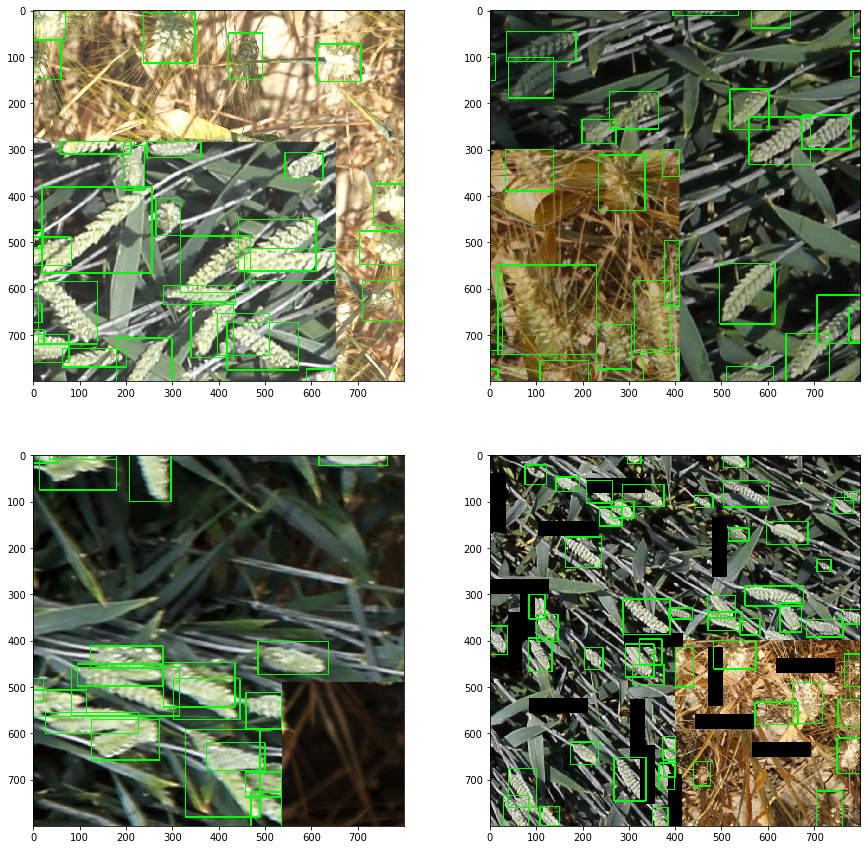

In [588]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.reshape(2*2)
batch = next(data_iter)
for i ,ax in enumerate(axes):
    images, target = batch
    image = images[i].permute(1, 2, 0).contiguous().numpy()
    bboxes = target[i]["boxes"]
    for box in bboxes:
        box = np.array(box).astype(int)
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
    ax.imshow(image)
    

## Metric

In [18]:
def iou_score(gt, pred) -> float:
    '''Computes the iou score between ground truth box and predicted box
    Args:
    gt: 1d array ground truth box [xmin, ymin, xmax, ymax]
    pred:1d array predicted box [xmin, ymin, xmax, ymax]
    Ouput:
    iou_score: float [0,1]'''
    #  if xmin_pred >= xmax_gt or xmax_pred <= xmin_gt return 0 (no intersection along x_axis)
    #  the same for y axis
    if (pred[0] >= gt[2] or pred[2] <= gt[0]) or (pred[1] >= gt[3] or pred[3] <= gt[1]):
        return 0
    
    max_x = min(pred[2], gt[2])
    min_x = max(pred[0], gt[0])
    max_y = min(pred[3], gt[3])
    min_y = max(pred[1], gt[1])
    intersection = (max_x - min_x) * (max_y - min_y)
    pred_area = (pred[2] - pred[0]) * (pred[3] - pred[1])
    gt_area = (gt[2] - gt[0]) * (gt[3] - gt[1])
    iou_score = intersection / (pred_area + gt_area - intersection)
    return iou_score

def find_best_match(pred, gts):
    '''Given a bounding box predictions, return the best matched groud truth
    bounding box.
    Args:
    pred: np.array (4,), predicted box
    gts: np.array(N, 4), ground truth bounding boxes
    Output:
    (gt box, score): tuple (matched box, score of match)'''
    index, max_match = max(enumerate(gts), key=lambda box: iou_score(box[1], pred))
    #print(iou_score(max_match, pred))
    return index, max_match, iou_score(max_match, pred)

def map_score(gts, preds, thresholds: list) -> float:
    ''' Compute map between predictions and ground truth'''
    ''' for threshold in thresholds:
            For box in predictions:
            find best matched score from ground truth (box, score)
            if score > threshold:
                tp ++
                update ground truch boxes (remove matched boxes)
            if score < threshold:
                fp ++
            for box in non-matched boxes:
                fn ++
            scores.add(tp/(tp+fp+fn))
        return the mean
    '''
    if len(gts) == 0:
        return 0, [0]

    thresholds = np.array(thresholds)
    positives = np.zeros((len(preds), len(thresholds)))
    matched_boxes = np.zeros((len(gts), len(thresholds)))
    
    for i, box in enumerate(preds):
        
        index, best_box, score = find_best_match(box, gts)
        mask = score >= thresholds
        matched_boxes[index, mask] += 1
        positives[i, mask] += 1
    
    tp = np.sum(matched_boxes>=1, axis=0)
    fp_matched = np.sum(matched_boxes, axis=0) - tp
    #print(fp_matched)
    fp_detected = len(preds) - np.sum(positives, axis=0)
    #print(fp_detected)
    fp = fp_matched + fp_detected
    fn = len(gts) - tp
    scores = tp/(tp + fp + fn)
    score = np.mean(scores)
    # print(fp)
    # print(positives)
    # print(matched_boxes)
    return score, scores

## Model

In [19]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def load_model():
    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # replace the classifier with a new one, that has
    # num_classes which is user-defined
    num_classes = 2  # 1 class (person) + background
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

def load_checkpoint(model, checkpoint_path=checkpoint_dir/'fasterrcnn_resnet50_fpn_epoch_13_.pth', device="cpu"):
    #checkpoint_path = path.parent/"input/checkpoint2/global_wheat_fasterrcnn_epoch_5.pth"
    checkpoint = torch.load(checkpoint_path, map_location=device)["model_state_dict"]
    for key in list(checkpoint.keys()):
            if 'model.' in key:
                checkpoint[key.replace('model.', '')] = checkpoint[key]
                del checkpoint[key]
    model.load_state_dict(checkpoint)
    return model

## Criterion and Optimizer

## Trainin Loop

In [20]:
def train_one_epoch(model, optimizer, lr_scheduler, data_loader, device, epoch, print_freq):
    model.train()
#     metric_logger = utils.MetricLogger(delimiter="  ")
#     metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)
    total_loss = 0
    loss_cls = 0
    loss_box_reg = 0
    loss_objectness = 0
    loss_rpn_box_reg = 0
    accumulation_steps = 4
    print(header)
    # lr_scheduler = None
    # if epoch == 0:
    #     warmup_factor = 1. / 1000
    #     warmup_iters = min(1000, len(data_loader) - 1)

    #     lr_scheduler = warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)
    optimizer.zero_grad()

    for i, (images, targets) in enumerate(data_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

#         # reduce losses over all GPUs for logging purposes
#         loss_dict_reduced = utils.reduce_dict(loss_dict)
#         losses_reduced = sum(loss for loss in loss_dict_reduced.values())

#         loss_value = losses_reduced.item()
        loss_value = losses.detach().item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            #print(loss_dict_reduced)
            sys.exit(1)
        
        losses.backward()
        if (i+1)%accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

            if lr_scheduler is not None:
                lr_scheduler.step()
            
        total_loss += loss_value/len(data_loader)
        loss_cls += loss_dict["loss_classifier"].item()/len(data_loader)
        loss_box_reg += loss_dict["loss_box_reg"].item()/len(data_loader)
        loss_objectness += loss_dict["loss_objectness"].item()/len(data_loader)
        loss_rpn_box_reg += loss_dict["loss_rpn_box_reg"].item()/len(data_loader)
        
        print(f"Train iteration: [{i+1}/{len(data_loader)}]\r", end="")
        #metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        #metric_logger.update(lr=optimizer.param_groups[0]["lr"])
    print()
    print(f"Train Loss: {total_loss:.4f} - loss_classfier: {loss_cls:.2f} - " \
         f"loss_box_reg: {loss_box_reg:.2f} - loss_objectness: {loss_objectness:.2f} - " \
         f"loss_rpn_box_reg: {loss_rpn_box_reg:.2f}")

In [21]:
def evaluate_(model, val_dataloader, device="cpu"):
    model.to(device)
    model.eval()
    map_scores = []
    with torch.no_grad():

        for i, batch in enumerate(val_dataloader):
            print(f"Validation iteration: [{i+1}/{len(val_dataloader)}]\r", end="")
            images, targets = batch
            images = [img.to(device) for img in images]
            predictions = model(images)
            for i, pred in enumerate(predictions):
                gts = pred["boxes"].detach().cpu().numpy()
                preds = targets[i]["boxes"].cpu().numpy()
                score, scores = map_score(gts, preds, thresholds=[.5, .55, .6, .65, .7, .75])
                map_scores.extend(scores)
        print()
    return np.mean(map_scores)

In [21]:

def lr_finder(train_loader, model, optimizer, criterion, accumulation_steps, device):
    model.zero_grad()
    lr_finder = LRFinder(model, optimizer, criterion, device=device)
    lr_finder.range_test(train_loader=train_loader, end_lr=100, num_iter=100, start_lr=1e-7, accumulation_steps=accumulation_steps)
    lr_finder.plot()  # to inspect the loss-learning rate graph
    lr_finder.reset()

## Experiment

In [23]:
import math
from torch.optim.lr_scheduler import OneCycleLR
nFolds = 1
nEpoch = 3
batch_size = 4
steps_per_epoch = 171
checkpoint_path = checkpoint_dir/"fasterrcnn_resnet50_fpn_epoch_13_.pth"

device = "cuda" if torch.cuda.is_available() else "cpu"
model = load_model()
model.to(device)
# model = load_checkpoint(model, checkpoint_path=checkpoint_path)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=0.0001)
lr_scheduler = OneCycleLR(optimizer=optimizer,
                                       max_lr=2e-4,
                                       epochs=nEpoch,
                                       steps_per_epoch=steps_per_epoch, # len(dataloader)/accumulations
                                       div_factor=1e2,  # for initial lr, default: 25
                                       final_div_factor=1e3,  # for final lr, default: 1e4
                                       )

for fold in range(nFolds):
    train_dataloader, valid_dataloader , annotated_dataloader = get_train_valid_dataloaders(fold)
    # define model, optimizer, lr_scheduler
    print(f"Fold: [{fold}/{nFolds}]")

    for epoch in range(nEpoch):
        train_one_epoch(model, optimizer, lr_scheduler, train_dataloader, device, epoch, 2)
        #evaluate(model, criterion, valid_loader, device, epoch, )
        validation_map_score = evaluate_(model, valid_dataloader, device=device)
        print(f"Validation Score: {validation_map_score}")
        test_map_score = evaluate_(model, annotated_dataloader, device=device)
        print(f"Test Score: {test_map_score}")
    checkpoint_ref = f"gwd_fasterrcnn_restnet50_fold_{fold}_{epoch}.pth"
    torch.save(model.state_dict(),checkpoint_ref)

Fold: [0/1]
Epoch: [0]


/opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Train iteration: [674/674]
Train Loss: 1.9675 - loss_classfier: 0.45 - loss_box_reg: 0.25 - loss_objectness: 0.62 - loss_rpn_box_reg: 0.64
Validation iteration: [169/169]
Validation Score: 0.01151807033560945
Validation iteration: [3/3]
Test Score: 0.011435468591883626
Epoch: [1]
Train iteration: [674/674]
Train Loss: 1.6091 - loss_classfier: 0.43 - loss_box_reg: 0.29 - loss_objectness: 0.34 - loss_rpn_box_reg: 0.55
Validation iteration: [169/169]
Validation Score: 0.013463188211322825
Validation iteration: [3/3]
Test Score: 0.013423719069342354
Epoch: [2]
Train iteration: [674/674]
Train Loss: 1.5846 - loss_classfier: 0.41 - loss_box_reg: 0.29 - loss_objectness: 0.33 - loss_rpn_box_reg: 0.55
Validation iteration: [169/169]
Validation Score: 0.014151658937109656
Validation iteration: [3/3]
Test Score: 0.0122187335533722


In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = load_model()
model.to(device)
model = load_checkpoint(model, checkpoint_path="gwd_fasterrcnn_restnet50_fold_0_2.pth")

KeyError: 'model_state_dict'

In [80]:
validation_map_score = evaluate_(model, valid_dataloader, device=device)
print(validation_map_score)

Validation iteration: [169/169]
0.4777000709700984


In [133]:
test_map_score = evaluate_(model, annotated_dataloader, device=device)
print(test_map_score)

Validation iteration: [3/3]
0.4788577033329593


## Inference

In [24]:
def inference(fold, checkpoint, device):
    test_loader = get_test_dataloader()
    predictions = dict()
    model = load_model()
    model.to(device)
    model = load_checkpoint(model, checkpoint, device)
    model.eval()
    with torch.no_grad():
        
        for image, target in test_loader:
            print(target)
            image = image.to(device)
            preds = model(image)
            for (p, t) in zip(preds, target):
                print(t)
                predictions[t] = p
    return predictions
    

In [25]:
device = torch.device("cuda")
checkpoint_path = checkpoint_dir/"fasterrcnn_resnet50_fpn_epoch_13_.pth"

predictions = inference(0, checkpoint=checkpoint_path, device=device)

('aac893a91', '51f1be19e', 'f5a1f0358', '796707dd7', '51b3e36ab', '348a992bb', 'cc3532ff6', '2fd875eaa', 'cb8d261a3', '53f253011')


/home/adnen/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


aac893a91
51f1be19e
f5a1f0358
796707dd7
51b3e36ab
348a992bb
cc3532ff6
2fd875eaa
cb8d261a3
53f253011


/opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


In [138]:
#predictions = inference(0)
submission = dict()
nboxes = 0
added_boxes = 0
image_ids = []
predictString = []
max_value = 0
for img_id, pred in predictions.items():
        boxes = pred["boxes"].cpu().numpy()#.tolist()
        max_value = max(max_value, boxes.max())
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        boxes = boxes.tolist()

        scores = pred["scores"].cpu().numpy()
        image_ids.append(img_id)
        pred_list = []
        nboxes += len(scores)
        for box, score in zip(boxes, scores):
            
            if score > 0.5:
                x = round(box[0])
                y = round(box[1])
                w = round(box[2])
                h = round(box[3])
#                 max_value = max(max_value, x+w)
#                 max_value = max(max_value, y+h)
                pred_list.append(f"{score} {x} {y} {w} {h}")
                print(f"{score} {x} {y} {w} {h}")
                added_boxes += 1
        
        predictionString = " ".join([str(i) for i in pred_list])
        predictString.append(predictionString)
        
submission = {"image_id": image_ids,
              "PredictionString": predictString}
sub_df = pd.DataFrame.from_dict(submission)
        
        

0.989658772945404 68 3 102 157
0.9865102171897888 616 917 79 106
0.9699632525444031 595 779 86 119
0.9637324810028076 31 455 85 139
0.9607571363449097 742 773 74 115
0.958536684513092 309 2 66 63
0.9578904509544373 238 846 98 76
0.9556080102920532 560 531 115 188
0.9404852390289307 88 619 122 68
0.9381948113441467 825 712 93 191
0.9248070120811462 462 857 75 95
0.9085538983345032 695 393 117 169
0.9023298621177673 180 573 102 182
0.8945457339286804 255 99 116 124
0.8802149891853333 68 859 110 65
0.8600835204124451 361 537 92 74
0.8194363713264465 336 672 96 127
0.7919272184371948 316 862 69 82
0.7393583655357361 557 74 132 178
0.6247225403785706 331 896 67 66
0.9674355983734131 508 475 190 100
0.965335488319397 610 87 154 168
0.963084876537323 846 278 123 186
0.9589694142341614 818 91 106 73
0.9427154064178467 33 1 74 67
0.9386830925941467 279 476 132 114
0.9327799081802368 816 769 91 85
0.9098324775695801 701 921 76 80
0.9073627591133118 773 891 137 86
0.9053488969802856 354 160 89 14

In [135]:
sub_df.head()
sub_df.to_csv("submission.csv", index=False)

In [136]:
sub_df.head()

,image_id,PredictionString
0,aac893a91,0.989658772945404 68 3 102 157 0.9865102171897...
1,51f1be19e,0.9674355983734131 508 475 190 100 0.965335488...
2,f5a1f0358,0.984687864780426 889 648 83 139 0.98249024152...
3,796707dd7,0.9768705368041992 898 333 98 84 0.97131943702...
4,51b3e36ab,0.9960858821868896 834 452 188 151 0.994353175...


In [117]:
sub_df.head()

,image_id,PredictionString
0,aac893a91,0.99339736 33 1 53 79 0.9893316 307 458 40 54 ...
1,51f1be19e,0.9864183 304 41 79 87 0.98588955 421 135 64 9...
2,f5a1f0358,0.988373 273 137 53 54 0.98789585 444 323 43 7...
3,796707dd7,0.9853521 450 167 50 44 0.9847565 356 415 52 4...
4,51b3e36ab,0.9965648 416 226 95 75 0.99566156 117 324 46 ...


In [132]:
max_value

1024.0

In [26]:
def show_prediction(index, thresh):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    image_ids = list(predictions.keys())
    idx = image_ids[index]
    boxes = predictions[idx]["boxes"].cpu().numpy()
    scores = predictions[idx]["scores"].cpu()
    image = cv2.imread(os.path.join(test_dir, idx+".jpg"), cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    print(image.shape)
    #image = cv2.resize(image, (512, 512))
    for i, box in enumerate(boxes):
        score = scores[i]
        if score>thresh:
            score_text = f"{scores[i]*100:.2f}%"
            cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 255, 0), 2)
            cv2.putText(image, score_text, (int(box[0]), int(box[1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,0,42), 2)
    ax.imshow(image)

(1024, 1024, 3)


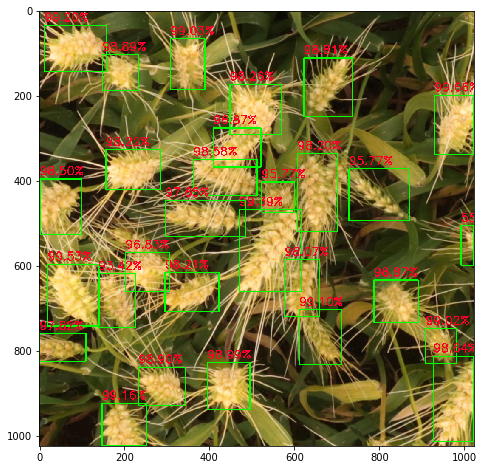

In [42]:
show_prediction(9, thresh=0.4)

In [543]:
boxes = [[0, 0, 100, 100],
         [150, 0, 300, 100],
         [0, 150, 100, 300],
         [200, 200, 250, 300],
         [400, 300, 500, 350]]
boxes= np.array(boxes)
boxes0 = boxes.copy()

In [544]:
image = np.ones((600, 600, 3)) * 255
cv2.rectangle(image, (0, 0), (200, 200), (0, 0, 255), 2, 1)

for box in boxes:
    cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2, 1)

In [545]:

boxes[:, [0, 2]] = np.clip(boxes[:, [0, 2]], a_min=200, a_max=None)
boxes[:, [1, 3]] = np.clip(boxes[:, [1, 3]], a_min=200, a_max=None)
mask1 = boxes[:, 2]>200
mask2 = boxes[:, 3]>200
mask = np.logical_or(mask1, mask2)
print(mask)
boxes = boxes0[mask]
maskx = (boxes[:, 0] < 200) * (boxes[:, 3] < 200)
masky = (boxes[:, 1] < 200) * (boxes[:, 2] < 200)

print(boxes)
boxes[maskx,[0]] = 200
boxes[masky, [1]] = 200
print(boxes)

[False  True  True  True  True]
[[150   0 300 100]
 [  0 150 100 300]
 [200 200 250 300]
 [400 300 500 350]]
[[200   0 300 100]
 [  0 200 100 300]
 [200 200 250 300]
 [400 300 500 350]]


In [546]:
for box in boxes:
    cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2, 1)
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


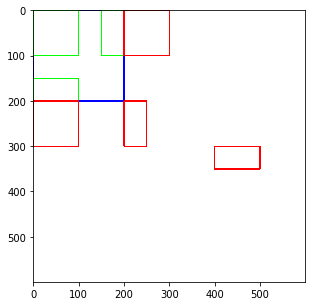

In [547]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(image)

In [501]:
boxes

array([[200, 200, 300, 200],
       [200, 200, 200, 300],
       [200, 200, 250, 300],
       [400, 300, 500, 350]])

In [502]:
boxes0

array([[200, 200, 200, 200],
       [200, 200, 300, 200],
       [200, 200, 200, 300],
       [200, 200, 250, 300],
       [400, 300, 500, 350]])

In [ ]:
from efficientnet_pytorch